# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [2]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 10
min_active_traits = 10
max_active_traits = 10

Using TensorFlow backend.


In [3]:
generate_student_name()

'YOFI BUCHE '

In [4]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [5]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/min_active_traits)
pr_k_hardest = q_p_hardest**(1/max_active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

# null_task_pr = 1/(1+exp(-baseline))
# print("null-task passrate", null_task_pr)
# print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**max_active_traits)
print("best Pr=", best_comp_pr**min_active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.182952867740814
th 4.719278893149851 7.902231760890665
worst cmp chance= 0.6309573444801932
best cmp chance= 0.9989954712917499
worst Pr= 0.01
best Pr= 0.9899999999999988
limits 0.976322758008557 0.976322758008557
[[1 2 3]
 [7 8 9]]
(2, 3)


In [6]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint,
                                     )
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [7]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt, n_active):
        self.id = qix
        
        if n_active:
            if len(n_active)==2:
                min_active = n_active[0]
                max_active = n_active[1]
            
                n_c =  numpy.random.choice(range(min_active, max_active+1))                
        else:
            n_c = nt


        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        


        for ix,c in enumerate(choices):
            self.betas[c] = uniform(beta_min, beta_max)
#             self.betas[c] = inv_sigmoid(uniform(min_txd, max_txd))
#             if ix == (len(choices)-1):
#                 topup = difficulty
#             else:
#                 topup = uniform(0, min(difficulty,(max_diff-min_diff)))
#             self.betas[c] += topup
#             difficulty -= topup
            
class Student():
    def __init__(self, ix, min_a, max_a, nt):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for ix,c in enumerate(choices):
            self.thetas[c] = uniform(theta_min, theta_max)
#             if ix == (len(choices)-1):
#                 topup = difficulty
#             else:
#                 topup = uniform(0, min(difficulty,(max_a-min_a)))
#             self.thetas[c] += topup
#             difficulty -= topup


In [8]:
def make_qs_in_blobs(n_qs, ndims, nblobs, min_dims_per_blob, max_dims_per_blob, min_d, max_d, keepdims=False):
    qix=0
    qs = []
    blobs = set()
    qs_per_blob = n_qs//nblobs
    used_dims = set()
    all_dims = set(range(ndims))
    while len(blobs) < nblobs:
        ndims_for_blob = randint(min_dims_per_blob, max_dims_per_blob)
        dims = tuple(sorted(numpy.random.choice(range(ndims), size=ndims_for_blob, replace=False)))
        blobs.add(dims) # create a list of lists
        #calculate blob centre
        used_dims.update(dims)
        print(dims)
        
    print("Unused dims:", all_dims.difference(used_dims) )

    if keepdims:
        used_dims = sorted(list(all_dims))
    else:
        ndims = len(used_dims)
        used_dims = sorted(list(used_dims))

    for blob in blobs:
        for _ in range(qs_per_blob):
            q = Question(qix, 0, 0, ndims, 0)
            qix+=1
            for dim in blob:
                diff = random.uniform(min_d, max_d)
                q.betas[ used_dims.index(dim) ] = diff
            qs.append(q)
            
            comps = [c for c in q.betas if c>0]
            mag = sqrt(sum([ pow(b, 2) for b in comps ]))
            print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
    return qs, ndims
        
make_qs_in_blobs(100, 10, 5, 3, 3, beta_min, beta_max)

(0, 4, 7)
(2, 4, 8)
(2, 3, 4)
(2, 5, 7)
(2, 4, 9)
Unused dims: {1, 6}
Q:0, difficulty=6.37 across 8 components
Q:1, difficulty=8.52 across 8 components
Q:2, difficulty=7.14 across 8 components
Q:3, difficulty=7.73 across 8 components
Q:4, difficulty=6.78 across 8 components
Q:5, difficulty=7.81 across 8 components
Q:6, difficulty=6.95 across 8 components
Q:7, difficulty=5.89 across 8 components
Q:8, difficulty=8.57 across 8 components
Q:9, difficulty=8.67 across 8 components
Q:10, difficulty=8.78 across 8 components
Q:11, difficulty=7.69 across 8 components
Q:12, difficulty=6.65 across 8 components
Q:13, difficulty=8.57 across 8 components
Q:14, difficulty=7.58 across 8 components
Q:15, difficulty=8.12 across 8 components
Q:16, difficulty=7.28 across 8 components
Q:17, difficulty=7.81 across 8 components
Q:18, difficulty=8.73 across 8 components
Q:19, difficulty=7.90 across 8 components
Q:20, difficulty=8.46 across 8 components
Q:21, difficulty=9.76 across 8 components
Q:22, difficulty

([<__main__.Question at 0x7f13344020f0>,
 8)

In [9]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [10]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
#     print("calc pp")
    for th,b in zip(thetas,betas):
#         print("th,b: ",th,b)
        if b==0:
#             print("\tGuar pass")
            p_pass_step=1.0
        else:
            if th==0:
#                 print("\tblocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
#     print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [11]:
def create_qs(n_qs, n_blobs=0, nt=n_traits, nnw=n_traits, keepdims=False):
    random.seed(666)
    numpy.random.seed(666)
  
    if n_blobs==0:
        master_qs = [Question(qix, beta_min,beta_max, nt, (min_active_traits, max_active_traits)) for qix in range(n_qs)]
        w = nt
    else:
        master_qs, w = make_qs_in_blobs(n_qs, nt, n_blobs, min_active_traits, max_active_traits, beta_min, beta_max, keepdims=keepdims)
    
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((len(master_qs), w),min_w=beta_min, max_w=beta_max)
    iQ_table = BigTable((len(master_qs), w),min_w=0, max_w=1)
    
    return master_qs, qn_table, iQ_table, w

In [12]:
def create_students(n_students, nt=n_traits, nnw=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    sQ_table = BigTable((n_students, nnw), min_w=0, max_w=1)
    print("psi_table wgts", psi_table.get_weights())
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)
    
    if nt>1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list, psi_table, sQ_table
    

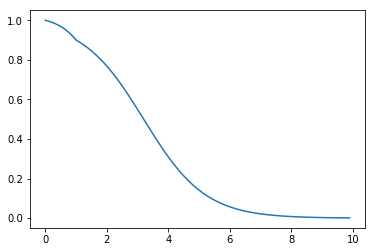

In [13]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    qn_qmx.trainable = True
    psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)

    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

x = numpy.arange(0,10,0.1)
y = numpy.clip(x,0,1)*(1/(1+numpy.exp(x-3.2))) + (1-numpy.clip(x,0,1))
# y = (1/(1+numpy.exp(x-3)))

plt.plot(x,y)


# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [14]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = False
    
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                pp,passed = attempt_q(psi, q)
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)

                qs.remove(qix)
    gc.collect()
    
    ct=0
    pct=0
    for a in attempts:
        ct+=1
        if a[2]:
            pct+=1
    print("passed {}/{}".format(pct,ct))
    
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [15]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])

    


In [16]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
#     out_q_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    
#     real_Qmx = numpy.ones(real_wgts.shape)
#     real_Qmx[real_wgts == 0] = 0
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
#                     pred_q_col = Qmx.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
#                     print("pc",pred_col)
#                     print("rc",real_col)
                    
                    #print("mae is ",mse)
#                     print("err < cur?", err, curr_err)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
#                         curr_q_sel = pred_q_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
#             out_q_cols[curr_real_ix] = curr_q_sel
        out_col_arr = array(out_cols).T
#         out_q_arr = array(out_q_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
#         total_q_err = numpy.mean(numpy.abs( out_q_arr - real_Qmx ))
        
        cos_dis = 0#cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
#         if cos_dis < best_cos_dis:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis


In [17]:
import os
import IPython

def calibrate(master_qs, psi_list,val, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    av_rmses = []
    init_patience = 20
    patience = init_patience

    print(attempts[0:100])
    shuffle(attempts)
    
    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    split = len_all//10
    vqices = qices[0:split]
    vpsices = psices[0:split]
    vpfs = pfs[0:split]
    
    qz = qices[split:]
    sz = psices[split:]
    pfz = pfs[split:]

    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    real_q_wgtz = array([ q.betas for q in master_qs ])
    real_s_wgtz = array([ s.thetas for s in psi_list ])
    real_wgtz = numpy.concatenate([real_q_wgtz, real_s_wgtz], axis=0)
#     real_wgtz = numpy.sort((real_wgtz).flatten())
    real_i_Qmx = numpy.ones(real_q_wgtz.shape)
    real_i_Qmx[real_q_wgtz==0]=0
    real_i_Qmx = numpy.sort(real_i_Qmx)
    
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))

#             psi_wgts = s_table.get_weights()[0]
#             psi_qmx_wgts = s_qmx_table.get_weights()[0]
            th_rmses = []
#             for s in psi_list:
# #                 masque = psi_qmx_wgts[s.id]
#                 spred = psi_wgts[s.id] #* masque
#                 sreal = s.thetas
#                 err = numpy.abs(numpy.sort(spred) - numpy.sort(sreal))
# #                 err = cosine(s_thetas, s_wgts)
#                 th_rmses.append(err)

            qn_wgts = numpy.sort(q_table.get_weights()[0])
            s_wgts = numpy.sort(s_table.get_weights()[0])
            sr_s_wgts = numpy.sort(real_s_wgtz)
            sr_q_wgts = numpy.sort(real_q_wgtz)
        
            serr = numpy.mean(numpy.abs(sr_s_wgts - s_wgts))
            qerr = numpy.mean(numpy.abs(sr_q_wgts - qn_wgts))
            print("s,qerr:",serr,qerr)
#             err = (serr + qerr)/2
            err = loss
#             pred_wgts = numpy.concatenate([qn_wgts, s_wgts], axis=0)
            
#             i_Qmx = q_qmx_table.get_weights()[0]
#             qmx_err = numpy.mean(numpy.abs(numpy.sort(i_Qmx) - real_i_Qmx))
#             print(numpy.sort(i_Qmx) - real_i_Qmx)

#             s_Qmx = s_qmx_table.get_weights()[0]
#             Qmx = numpy.concatenate([i_Qmx, s_Qmx])

#             pred_wgts = numpy.sort(pred_wgts * Qmx)
#             w_err = numpy.mean(numpy.abs(real_wgtz - pred_wgts))
            
#             err = (qmx_err + w_err) / 2
#             err = qmx_err
    
#             b_rmses = []
#             for q in master_qs:
# #                 masque = qn_qmx_wgts[q.id]
# #                 print("masque =", masque)
#                 qpred = numpy.sort(qn_wgts[q.id])
#                 print("qpred =", qpred)
#                 qreal = numpy.sort(q.betas)
#                 print("qreal =", qreal)
#                 err = numpy.abs(qpred - qreal)
# #                 err = cosine(q_betas, q_wgts)
#                 b_rmses.append(err)
            
#             _, av_rmse, qerr, serr, _, _, Qmx_err = calc_arr_arr_err(len(master_qs), real_wgtz, pred_wgts, Qmx, max_iter=10)
#             b_fit_rmses.append(qerr)
#             th_fit_rmses.append(serr)
        
#             print("i =",i)
#             th_rmse = numpy.mean(th_rmses)
#             th_fit_rmses.append(th_rmse)

#             print("th RMSE=", th_rmse)
#             b_rmse = min_total_err
# #             b_rmse = numpy.mean(b_rmses)
#             b_fit_rmses.append(b_rmse)
#             print("b RMSE=", b_rmse)
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse =(th_rmse+b_rmse)/2.0
#             print("RMSE=",av_rmse)
#             print("QMxE=",Qmx_err)

#             print("wgt err=",w_err)
#             print("qmx err=",qmx_err)

            av_rmses.append(err)
        
            if err <= min_avg_fit_rmse:
                print("new better score")
                patience = init_patience
#                 print("patience reset to", init_patience)
                min_avg_fit_rmse = err
                min_loss = loss
                qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                    else:
                        print("Earlying stoppin' @",i)
                        break
            print("patience now", patience)
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, b_fit_rmses, th_fit_rmses, av_rmses


Q:0, difficulty=9.19 across 10 components
Q:1, difficulty=9.85 across 10 components
Q:2, difficulty=8.83 across 10 components
Q:3, difficulty=7.32 across 10 components
Q:4, difficulty=10.42 across 10 components
Q:5, difficulty=9.87 across 10 components
Q:6, difficulty=8.40 across 10 components
Q:7, difficulty=9.28 across 10 components
Q:8, difficulty=9.38 across 10 components
Q:9, difficulty=5.95 across 10 components
Q:10, difficulty=9.74 across 10 components
Q:11, difficulty=10.24 across 10 components
Q:12, difficulty=7.65 across 10 components
Q:13, difficulty=8.46 across 10 components
Q:14, difficulty=8.34 across 10 components
Q:15, difficulty=8.25 across 10 components
Q:16, difficulty=8.66 across 10 components
Q:17, difficulty=6.58 across 10 components
Q:18, difficulty=9.86 across 10 components
Q:19, difficulty=9.58 across 10 components
Q:20, difficulty=9.95 across 10 components
Q:21, difficulty=9.04 across 10 components
Q:22, difficulty=8.64 across 10 components
Q:23, difficulty=7.

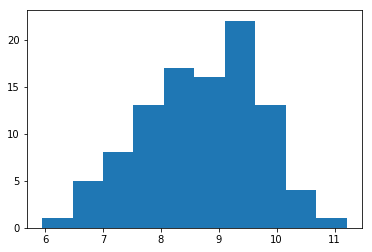

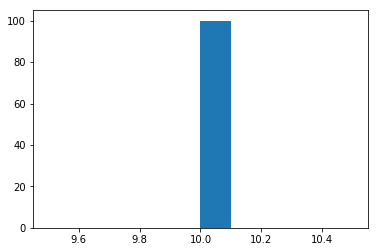

W0828 20:21:17.591035 139720581351232 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



qid 0 [2.3825967333138998, 1.3919554805595131, 2.22700819265764, 3.58251899669851, 2.7623174266549535, 2.4518073447441746, 3.5933419214631206, 3.875235023458159, 3.266818720926616, 2.5934711611230954]
qid 1 [3.9335970543414036, 2.9432329603656626, 4.079366636374205, 3.0024273506839028, 3.838639130277617, 1.316322674010022, 1.5403727680992807, 1.0533627005862138, 3.1693510517026313, 4.147360540580727]
qid 2 [2.974194934022506, 2.337049146693444, 3.2360694327383928, 1.41452524633943, 3.8685587401897137, 2.682227793550025, 1.274876580987812, 2.6457368760175757, 1.9903844679036626, 4.056007955684153]
qid 3 [1.1095462393359103, 1.1460095938271633, 2.4672526468485874, 3.3463012022844354, 1.6923395977376978, 1.8149476893503511, 3.6637581981069145, 3.419503913291837, 1.161825391943805, 1.0444164658701973]
qid 4 [3.528920559847211, 3.960372796413923, 3.3913587518768042, 3.602144672759419, 3.9246937842373946, 2.594594942246231, 3.9522746097780357, 2.356605879677786, 2.693001976006048, 2.33459916

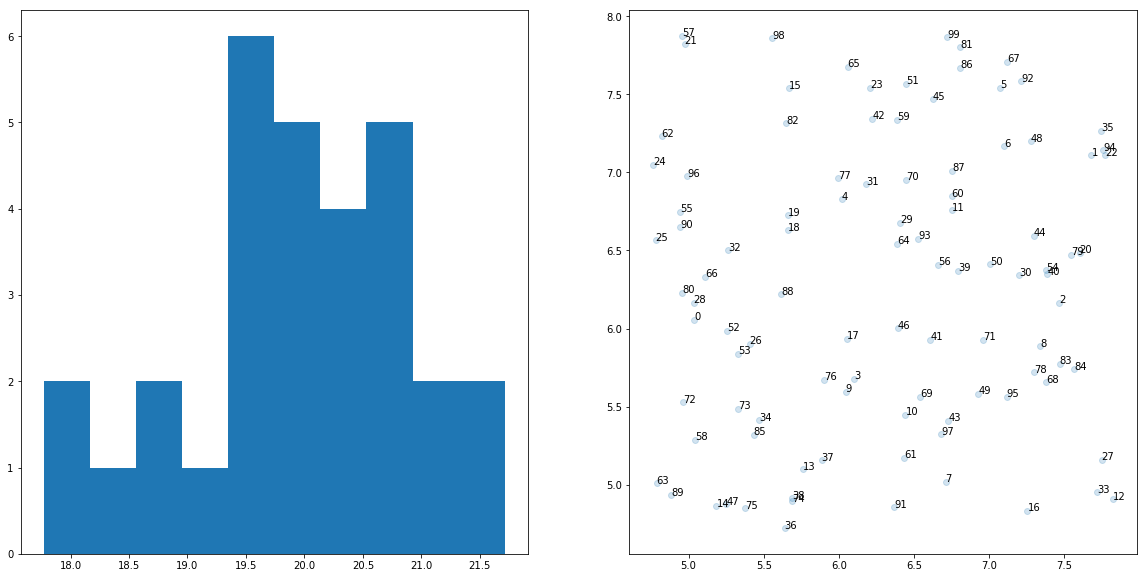

----0

passed 6066/10000
----0



W0828 20:21:18.544149 139720581351232 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 20:21:18.548223 139720581351232 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 20:21:18.591089 139720581351232 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 20:21:18.598781 139720581351232 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0828 2

passed 6185/10000
<__main__.BigTable object at 0x7f12f1f8c2e8> <__main__.BigTable object at 0x7f12f133ea20> Tensor("psi_select:0", shape=(?, 1), dtype=int32) Tensor("q_select:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (100, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 10)
'rows' shape, (?, 10)
kk (100, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 10)
'rows' shape, (?, 10)
dif (?, 10)
Pr (?, 1)
[(0, 77, 0, 0), (0, 24, 1, 1), (0, 61, 1, 1), (0, 21, 0, 0), (0, 39, 1, 1), (0, 83, 1, 1), (0, 55, 1, 1), (0, 62, 0, 0), (0, 82, 0, 0), (0, 51, 1, 1), (0, 42, 1, 1), (0, 90, 0, 0), (0, 9, 0, 0), (0, 7, 0, 0), (0, 49, 1, 1), (0, 63, 0, 0), (0, 89, 0, 0), (0, 11, 0, 0), (0, 25, 0, 0), (0, 73, 1, 1), (0, 10, 1, 1), (0, 22, 0, 0), (0, 56, 1, 1), (0, 44, 0, 0), (0, 81, 1, 1), (0, 95, 1, 1), (0, 54, 1, 1), (0, 19, 0, 0), (0, 43, 1, 1), (0, 48, 1, 1), (0, 97, 1, 1), (0, 92, 1, 1), (0, 70, 0, 0), (0, 80, 0, 0), (0, 12, 1, 1), (0, 84, 1, 1), (0, 60, 0, 0

W0828 20:21:18.792434 139720581351232 deprecation.py:323] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:175: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
W0828 20:21:18.852664 139720581351232 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



s,qerr: 0.43623843678443 0.4523424673747224
0.6992335467338562 0.2500890853404999 0.593
new better score
patience now 20
s,qerr: 0.4325466525267537 0.4482505617506474
0.6972981715202331 0.24926107835769654 0.594
new better score
patience now 20
s,qerr: 0.42881331807763406 0.44411798432198313
0.6953631567955018 0.2484310507774353 0.6
new better score
patience now 20
s,qerr: 0.4252121967568325 0.44005707616681977
0.6934968981742858 0.24762959933280945 0.597
new better score
patience now 20
s,qerr: 0.42183355904909625 0.43623712457239333
0.6917015419006348 0.24685811734199523 0.6
new better score
patience now 20
s,qerr: 0.418630633310742 0.4326074660720017
0.6899849643707275 0.24612059998512267 0.599
new better score
patience now 20
s,qerr: 0.41572663894817824 0.4291847207113075
0.6883473892211914 0.2454173195362091 0.602
new better score
patience now 20
s,qerr: 0.41311568229546264 0.42588603329262603
0.686774079322815 0.24474114966392518 0.602
new better score
patience now 20
s,qerr: 0.4

s,qerr: 0.34245435008471276 0.3471969588030976
0.65065256690979 0.22922917008399962 0.636
new better score
patience now 20
s,qerr: 0.34212404095098853 0.34697276968169755
0.6504895124435425 0.2291598427295685 0.636
new better score
patience now 20
s,qerr: 0.34176756270385994 0.34678706793984565
0.6503292398452759 0.2290916484594345 0.636
new better score
patience now 20
s,qerr: 0.34142463385502414 0.34668405866991386
0.6501707940101623 0.2290240867137909 0.637
new better score
patience now 20
s,qerr: 0.3410771030131967 0.3465960208193851
0.6500241680145263 0.22896201372146607 0.634
new better score
patience now 20
s,qerr: 0.3407470071155986 0.34660017277840716
0.6498827929496765 0.2289021873474121 0.631
new better score
patience now 20
s,qerr: 0.3404667695004663 0.346594145139947
0.6497433795928955 0.22884349822998046 0.633
new better score
patience now 20
s,qerr: 0.3402268650432022 0.34666713651439107
0.6496105856895447 0.2287877777814865 0.633
new better score
patience now 20
s,qerr:

In [18]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 100
n_students = 100
opt = Adam() #Adam(lr=0.01)# (lr=.75)

for ix,nnw in enumerate(nn_dimensions):
    n_blobs = 0
    qs, q_table, iqmx, nnw = create_qs(n_qs, n_blobs, n_traits, nnw, keepdims=True)
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
    ss, s_table, sqmx = create_students(n_students, nnw, nnw)
    attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
    val, _,_,_ = generate_attempts(qs,ss)
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, iqmx, sqmx, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
#     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
#     halfmin_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
 
    h, b_fit_rmses, th_fit_rmses, av_rmses = calibrate(qs,ss,val, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, sqmx, iqmx, n_iter=100000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_summative.hdf5")


In [19]:
tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
random.seed(42)
numpy.random.seed(42)
X=[]
for _ in range(10):
    x, _,_,_ = generate_attempts(qs,ss)
    X.extend(x)

N = len(X)
print("{} test items".format(N))
real_passes = 0
est_passes = 0
# xr,_,_,_ = generate_attempts(qs,ss)
for tup in X:
    (psi_id, q_id, passed, passed) = tup
    p,epassed = attempt_q(ss[psi_id], qs[q_id])

    summa += log((p if passed else 1-p), base)
    
#     print("ppass=", p, passed,epassed)
    
    if passed:
        real_passes+=1
#         if att <= p:
        if epassed:
            est_passes+=1
            tp+=1
        else:
            fn+=1
    else:
#         if att <= p:
        if epassed:
            est_passes+=1
            fp+=1
        else:
            tn+=1

    
print("real passes: {}/{}".format(real_passes, N))
print("estimated passes: {}".format(est_passes))
acc = (tp+tn)/N
print("model acc:",acc)
print(tp,fp)
print(tn,fn)
ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))

----0

passed 6253/10000
----0

passed 6167/10000
----0

passed 6235/10000
----0

passed 6124/10000
----0

passed 6099/10000
----0

passed 6258/10000
----0

passed 6195/10000
----0

passed 6134/10000
----0

passed 6164/10000
----0

passed 6125/10000
100000 test items
real passes: 61754/100000
estimated passes: 61530
model acc: 0.55994
39639 21891
16355 22115
perplexity is 1.8783345986984443


In [20]:
tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
sw = s_table.get_weights()[0]
qw = q_table.get_weights()[0]

random.seed(42)
numpy.random.seed(42)
X=[]
for _ in range(10):
    x, _,_,_ = generate_attempts(qs,ss)
    X.extend(x)

N = len(X)
print("{} test items".format(N))
real_passes = 0
est_passes = 0
for tup in X:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(sw[psi_id], qw[q_id])
 
    att = uniform(0,1)
    epassed = True if att<=p else False
    
    summa += log((p if passed else 1-p), base)
    
    
    if passed:
        real_passes+=1
#         if att <= p:
        if epassed:
            est_passes+=1
            tp+=1
        else:
            fn+=1
    else:
#         if att <= p:
        if epassed:
            est_passes+=1
            fp+=1
        else:
            tn+=1
    
print("real passes: {}/{}".format(real_passes, N))
print("estimated passes: {}".format(est_passes))
acc = (tp+tn)/N
print("model acc:",acc)
print(tp,fp)
print(tn,fn)
ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))

----0

passed 6253/10000
----0

passed 6167/10000
----0

passed 6235/10000
----0

passed 6124/10000
----0

passed 6099/10000
----0

passed 6258/10000
----0

passed 6195/10000
----0

passed 6134/10000
----0

passed 6164/10000
----0

passed 6125/10000
100000 test items
real passes: 61754/100000
estimated passes: 60444
model acc: 0.5442
38309 22135
16111 23445
perplexity is 1.9230427843467097


elements in h: 120
(0.6992335467338562, 0.2500890853404999, 0.593)
(0.6972981715202331, 0.24926107835769654, 0.594)
(0.6953631567955018, 0.2484310507774353, 0.6)
(0.6934968981742858, 0.24762959933280945, 0.597)
(0.6917015419006348, 0.24685811734199523, 0.6)
(0.6899849643707275, 0.24612059998512267, 0.599)
(0.6883473892211914, 0.2454173195362091, 0.602)
(0.686774079322815, 0.24474114966392518, 0.602)
(0.6852752494812012, 0.2440971472263336, 0.607)
(0.683843782901764, 0.24348228764533997, 0.608)
(0.6824828243255615, 0.24289794766902922, 0.608)
(0.6811787595748902, 0.24233805692195892, 0.61)
(0.6799127616882324, 0.24179379415512084, 0.615)
(0.6786929354667663, 0.24126919507980346, 0.614)
(0.6775182752609253, 0.240763818025589, 0.614)
(0.6763867082595825, 0.24027650606632234, 0.619)
(0.675290846824646, 0.2398042217493057, 0.619)
(0.6742330770492554, 0.2393483576774597, 0.616)
(0.6732137465476989, 0.23890909028053284, 0.616)
(0.6722320232391358, 0.2384860472679138, 0.615)
(0.671288644790649

<Figure size 432x288 with 0 Axes>

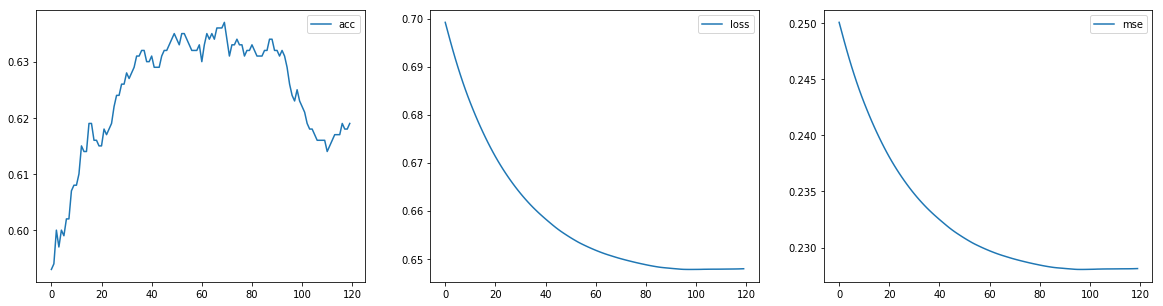

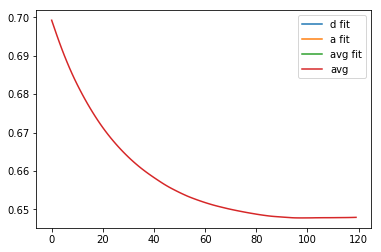

In [21]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg fit")
plt.plot(av_rmses, label="avg")
plt.legend()
plt.show()


In [22]:
real_wgtz = array([ q.betas for q in qs ])
real_s_wgtz = array([ s.thetas for s in ss ])

pred_wgtz = q_table.get_weights()[0]
items_chosen, min_total_err, qerr, serr, mean_ll, cos_dis = calc_arr_arr_err(0, real_wgtz, pred_wgtz, max_iter=10)

# print("q real", real_wgtz)
# print("q out", chosen)
print("q best cos distance:", cos_dis)
print("q elementwise mae:", min_total_err)
print("q mean lead/lag", mean_ll)

pred_wgtz = s_table.get_weights()[0]
print("s min = ", numpy.min(pred_wgtz))
# pred_wgtz[pred_wgtz<1]=0
chosen, min_total_err, qerr, serr, mean_ll, cos_dis = calc_arr_arr_err(0, real_s_wgtz, pred_wgtz, max_iter=10)

# print("s real", real_wgtz)
# print("s out", chosen)
print("s best cos distance:", cos_dis)
print("s elementwise mae:", min_total_err)
print("s mean lead/lag", mean_ll)

q best cos distance: 0
q elementwise mae: 0.9680752316141068
q mean lead/lag -0.035323872382427776
s min =  4.719279
s best cos distance: 0
s elementwise mae: 0.9336859437800171
s mean lead/lag -0.011116539373968856


/home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(100, 10) (100, 10)


/home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


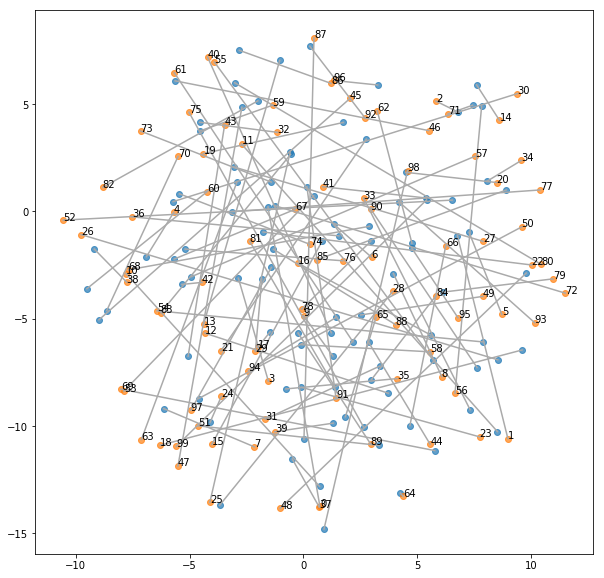

In [25]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)


itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = items_chosen
n = len(items_chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()